In [25]:
import numpy as np

from hoomd.neb_plugin import neb
import hoomd
import freud
import gsd.hoomd
import monk
from monk import prep, pair, render

import matplotlib.pyplot as plt

import multiprocessing as mp
import multiprocessing.pool as mpp
import multiprocessing.shared_memory as sm
import zmq

In [26]:
def make_snap(box, pos):
    snap = gsd.hoomd.Snapshot()
    snap.configuration.box = list(box.L) + [0, 0, 0]
    snap.configuration.dimensions = 2
    snap.particles.N = len(pos)
    snap.particles.position = pos
    snap.particles.types = ["A"]
    snap.particles.diameter = np.ones(len(pos))*0.5

    return snap

In [27]:
# prepare lattice with a defect

Nx = 10

snap_box, snap_pos = freud.data.UnitCell.hex().generate_system((Nx, Nx, 1), scale=0.6)

future_pos = np.copy(snap_pos)
mid = future_pos[Nx*Nx,:].copy()
future_pos[Nx*Nx,:] = future_pos[0,:]
# future_pos[Nx*(Nx+1),:] = mid

snap_pos = np.delete(snap_pos, 0, axis=0)
future_pos = np.delete(future_pos, 0, axis=0)

snap = make_snap(snap_box, snap_pos)
future_snap = make_snap(snap_box, future_pos)

sim = hoomd.Simulation(device=hoomd.device.CPU())
sim.create_state_from_snapshot(snap)

In [29]:
len(snap_pos)

199

In [30]:
ids = np.ravel(np.argwhere(np.linalg.norm(snap_pos - snap_pos[0, :], axis=-1) < 4)).astype(np.uint32)
print(len(ids))
filter = hoomd.filter.Tags(ids)

139


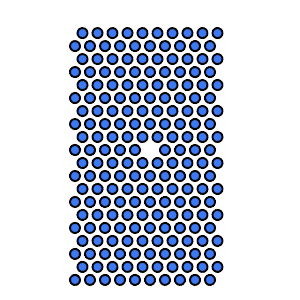

In [31]:
render.render_disk_frame(sim.state.get_snapshot(), Nx*.6*2)

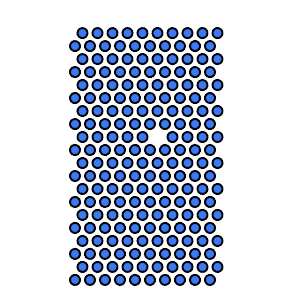

In [32]:
render.render_disk_frame(future_hoomd_snap, Nx*.6*2)

In [33]:
def setup_node(sim, k, force, filter):
    neb_integrator = neb.NEB(0.01, 1e-3, 1e-3, 1e-3, k=k)
    if force:
        nlist = hoomd.md.nlist.Cell(0.3)
        hertzian = pair.bi_hertz(nlist)
        neb_integrator.forces = [hertzian]
    nve = hoomd.md.methods.DisplacementCapped(filter, 0.01)
    neb_integrator.methods = [nve]

    sim.operations.integrator = neb_integrator

    sim.run(0)

def make_node(box, pos, device=hoomd.device.CPU(), k=1.0, force=True, filter=hoomd.filter.All()):
    sim = hoomd.Simulation(device=device)
    snap = make_snap(box, pos)
    sim.create_state_from_snapshot(snap)
    setup_node(sim, k, force, filter)
    return sim

def couple_neb_minimizers(sims):

    for i in range(len(sims)):
        minimizer = sims[i].operations.integrator
        assert isinstance(minimizer, neb.NEB)

    for i in range(len(sims)-1):
        left_minimizer = sims[i].operations.integrator
        assert isinstance(left_minimizer, neb.NEB)
        right_minimizer = sims[i+1].operations.integrator
        assert isinstance(right_minimizer, neb.NEB)
        left_minimizer.couple_right(right_minimizer)
        right_minimizer.couple_left(left_minimizer)


In [34]:
neb_sims = []

images = 20
k=100.0
filter = hoomd.filter.All()

start = make_node(snap_box, snap_pos, k=k, force=True, filter=filter)
end = make_node(snap_box, future_pos, k=k, force=True, filter=filter)

In [41]:
start.operations.integrator.nudge = False
energy = []
start.state.thermalize_particle_momenta(hoomd.filter.All(), kT=1.0)
for i in range(500):
    start.run(10)
    energy.append(start.operations.integrator.energy)
start.operations.integrator.nudge = True

end.operations.integrator.nudge = False
end.state.thermalize_particle_momenta(hoomd.filter.All(), kT=1.0)
for i in range(500):
    end.run(10)
    energy.append(end.operations.integrator.energy)
end.operations.integrator.nudge = True

plt.plot(energy)
plt.yscale('log')

*Warning*: Simulation.seed is not set, using default seed=0


In [36]:
start.operations.integrator.converged, end.operations.integrator.converged

(True, True)

In [37]:
snap_pos = start.state.get_snapshot().particles.position
future_pos = end.state.get_snapshot().particles.position
freud_box = freud.Box.from_box(start.state.box)
neb_sims.append(start)
disp = freud_box.wrap(future_pos - snap_pos)
for i in range(images):
    f = float(i+1)/float(images+1)
    pos = snap_pos + disp*f
    neb_sims.append(make_node(snap_box, freud_box.wrap(pos), k=k, filter=filter))
neb_sims.append(end)

couple_neb_minimizers(neb_sims)

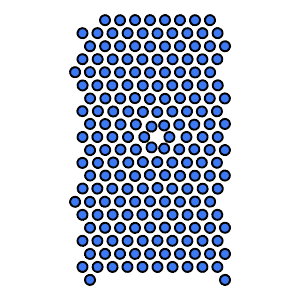

In [40]:
render.render_disk_frame(neb_sims[-1].state.get_snapshot(), Nx*0.6*2)

def run(sim: hoomd.Simulation):
    sim.run(1000, release_gil=True)

with mpp.ThreadPool(images+2) as pool:
    pool.map(run, neb_sims)

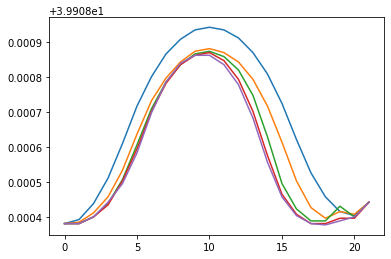

In [39]:
energy = []

def run_small(sim: hoomd.Simulation):
    sim.run(500, release_gil=True)

energy = []
for sim in neb_sims:
    # print(len(sim.operations.integrator.forces))
    energy.append(sim.operations.integrator.forces[0].energy)

for i in range(5):
    with mpp.ThreadPool(images+2) as pool:
        pool.map(run_small, neb_sims)

    energy = []
    for sim in neb_sims:
        # print(len(sim.operations.integrator.forces))
        energy.append(sim.operations.integrator.forces[0].energy)

    plt.plot(energy)
    

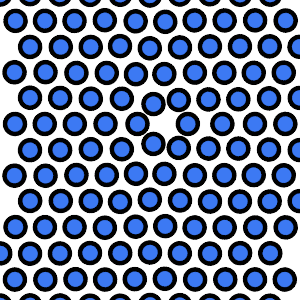

In [40]:
render.render_disk_frame(neb_sims[14].state.get_snapshot(), Nx*.6)

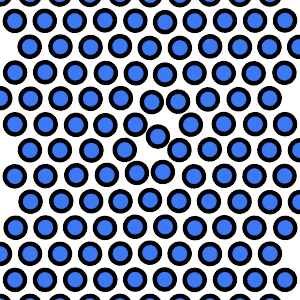

In [107]:
render.render_disk_frame(neb_sims[20].state.get_snapshot(), Nx*.6)

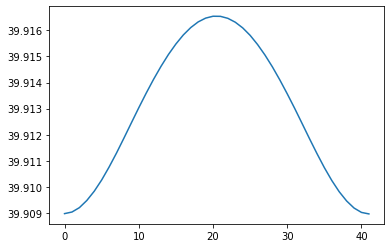

In [122]:
energy = []

for sim in neb_sims:
    # print(len(sim.operations.integrator.forces))
    energy.append(sim.operations.integrator.forces[0].energy)

plt.plot(energy)

In [37]:
print(energy)

[7941.887283325195, 7941.886524200439, 7941.885765075684, 7941.883487701416, 7941.881210327148, 7941.879692077637, 7941.877414703369, 7941.875137329102, 7941.871341705322, 7941.869823455811, 7941.869064331055, 7941.868305206299, 7941.868305206299, 7941.869823455811, 7941.872100830078, 7941.875896453857, 7941.886524200439, 7941.912334442139, 7941.937385559082, 7941.954086303711, 7941.963195800781, 7941.963954925537, 7941.955604553223, 7941.938903808594, 7941.91385269165, 7941.886524200439, 7941.875137329102, 7941.869064331055, 7941.866786956787, 7941.865268707275, 7941.865268707275, 7941.866027832031, 7941.8645095825195, 7941.866786956787, 7941.868305206299, 7941.871341705322, 7941.87361907959, 7941.875896453857, 7941.879692077637, 7941.881969451904]
